
# MNIST - CNN (PyTorch) + Camara en Vivo (OpenCV)

Cuaderno para Anaconda + Jupyter (Windows 11).  
Incluye dos partes:
1. Entrenamiento y validacion de una CNN en MNIST (usa GPU si esta disponible).
2. Inferencia con camara en vivo para reconocer digitos en una ROI.

Todo comentado en espanol. El mejor modelo se guarda en ./checkpoints/mnist_cnn_best.pt


## 1) Librerias, configuracion y dispositivo

In [1]:
import os, time, random, itertools
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from sklearn.metrics import classification_report, confusion_matrix
import cv2

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Dispositivo:", DEVICE)
if DEVICE.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)


Dispositivo: cpu


## 2) Dataset MNIST y DataLoaders

C:\Users\VICTORIA\anaconda3\envs\numeric\Lib\site-packages\torch\utils\data\dataloader.py:775: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  super().__init__(loader)


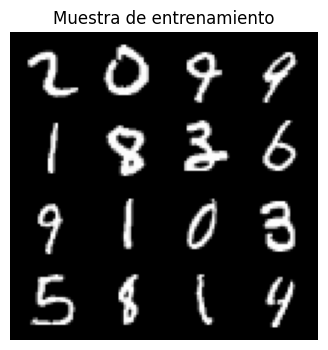

In [2]:

MNIST_MEAN, MNIST_STD = (0.1307,), (0.3081,)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MNIST_MEAN, MNIST_STD)
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True,  download=True, transform=transform)
test_ds   = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_ratio = 0.1
n_val = int(len(train_full)*val_ratio)
n_train = len(train_full) - n_val
train_ds, val_ds = random_split(train_full, [n_train, n_val], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 256 if DEVICE.type == "cuda" else 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

imgs, lbls = next(iter(train_loader))
grid = make_grid(imgs[:16].cpu(), nrow=4, padding=2, normalize=True)
plt.imshow(grid.permute(1,2,0).numpy(), cmap="gray"); plt.axis("off"); plt.title("Muestra de entrenamiento"); plt.show()


## 3) Definicion del modelo (CNN)

In [5]:

class MNIST_CNN(nn.Module):
    # CNN simple para MNIST
    # Conv(32) ReLU MaxPool; Conv(64) ReLU MaxPool; Dropout; FC(128) ReLU; Dropout; FC(10)
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(inplace=True), nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(64*7*7, 128), nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

model = MNIST_CNN().to(DEVICE)
print(model)


MNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.25, inplace=False)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=3136, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [6]:
# python -m pip install torchinfo
from torchinfo import summary
summary(model, input_size=(1, 1, 28, 28),
        col_names=("kernel_size","output_size","num_params","trainable"))


Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #                   Trainable
MNIST_CNN                                --                        [1, 10]                   --                        True
├─Sequential: 1-1                        --                        [1, 64, 7, 7]             --                        True
│    └─Conv2d: 2-1                       [3, 3]                    [1, 32, 28, 28]           320                       True
│    └─ReLU: 2-2                         --                        [1, 32, 28, 28]           --                        --
│    └─MaxPool2d: 2-3                    2                         [1, 32, 14, 14]           --                        --
│    └─Conv2d: 2-4                       [3, 3]                    [1, 64, 14, 14]           18,496                    True
│    └─ReLU: 2-5                         --                        [1, 64, 14, 14]           --                        --
│    └─Ma

In [7]:
# python -m pip install torchsummary
from torchsummary import summary
summary(model, (1, 28, 28))   # (C,H,W)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
           Dropout-7             [-1, 64, 7, 7]               0
           Flatten-8                 [-1, 3136]               0
            Linear-9                  [-1, 128]         401,536
             ReLU-10                  [-1, 128]               0
          Dropout-11                  [-1, 128]               0
           Linear-12                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
-------------------------------

## 4) Perdida, Optimizador, Scheduler y EarlyStopping

In [8]:
# === Configuración de pérdida, optimizador y scheduler ===
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Reduce el LR cuando la pérdida de validación deja de mejorar
# (En algunas versiones de PyTorch no existe el argumento 'verbose')
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=2
)

class EarlyStopping:
    # Detiene el entrenamiento si la val_loss no mejora
    def __init__(self, patience=5, min_delta=1e-4):
        self.patience, self.min_delta = patience, min_delta
        self.best, self.count, self.stop = None, 0, False
    def step(self, val):
        if self.best is None or val < self.best - self.min_delta:
            self.best, self.count = val, 0
        else:
            self.count += 1
            if self.count >= self.patience:
                self.stop = True

early = EarlyStopping()

from pathlib import Path
ckpt_dir = Path("./checkpoints"); ckpt_dir.mkdir(parents=True, exist_ok=True)
ckpt_path = ckpt_dir / "mnist_cnn_best.pt"

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train(); tl=0.0; ok=0; tot=0
    for x,y in loader:
        x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x); loss = criterion(logits, y)
        loss.backward(); optimizer.step()
        tl += loss.item()*x.size(0); ok += (logits.argmax(1)==y).sum().item(); tot += x.size(0)
    return tl/tot, ok/tot

@torch.no_grad()
def evaluate(model, loader, criterion, device):
    model.eval(); tl=0.0; ok=0; tot=0; allp, ally = [], []
    for x,y in loader:
        x,y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x); loss = criterion(logits, y)
        tl += loss.item()*x.size(0); ok += (logits.argmax(1)==y).sum().item(); tot += x.size(0)
        allp.append(logits.argmax(1).cpu()); ally.append(y.cpu())
    return tl/tot, ok/tot, torch.cat(allp).numpy(), torch.cat(ally).numpy()


## 5) Entrenamiento con validacion

Ep 01/10 | train_loss=0.2709 acc=0.9172 | val_loss=0.0729 acc=0.9775 | 65.6s
Ep 02/10 | train_loss=0.0996 acc=0.9706 | val_loss=0.0520 acc=0.9852 | 57.1s
Ep 03/10 | train_loss=0.0743 acc=0.9775 | val_loss=0.0460 acc=0.9877 | 50.1s
Ep 04/10 | train_loss=0.0628 acc=0.9811 | val_loss=0.0481 acc=0.9875 | 47.5s
Ep 05/10 | train_loss=0.0560 acc=0.9827 | val_loss=0.0462 acc=0.9880 | 46.0s
Ep 06/10 | train_loss=0.0493 acc=0.9850 | val_loss=0.0451 acc=0.9887 | 45.9s
Ep 07/10 | train_loss=0.0458 acc=0.9855 | val_loss=0.0357 acc=0.9908 | 48.0s
Ep 08/10 | train_loss=0.0416 acc=0.9876 | val_loss=0.0343 acc=0.9907 | 47.4s
Ep 09/10 | train_loss=0.0383 acc=0.9880 | val_loss=0.0363 acc=0.9903 | 49.2s
Ep 10/10 | train_loss=0.0392 acc=0.9877 | val_loss=0.0371 acc=0.9903 | 52.4s


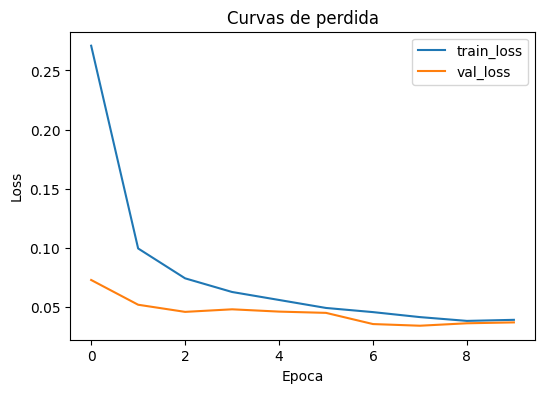

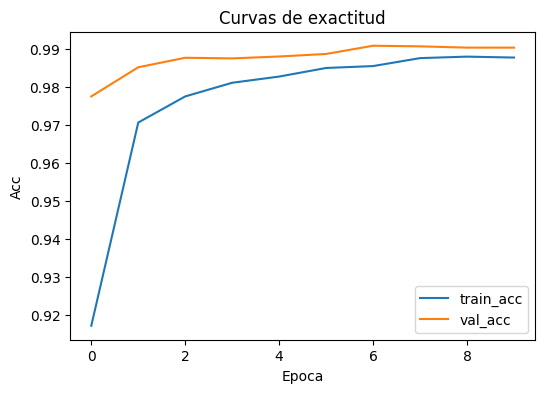

In [9]:

EPOCHS = 10
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best = float("inf")

for ep in range(1, EPOCHS+1):
    t0=time.time()
    tr_l,tr_a = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_l,val_a,_,_ = evaluate(model, val_loader, criterion, DEVICE)

    scheduler.step(val_l); early.step(val_l)
    if val_l < best:
        best = val_l
        torch.save({"model": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "epoch": ep}, ckpt_path)

    history["train_loss"].append(tr_l); history["train_acc"].append(tr_a)
    history["val_loss"].append(val_l);  history["val_acc"].append(val_a)

    dt=time.time()-t0
    print(f"Ep {ep:02d}/{EPOCHS} | train_loss={tr_l:.4f} acc={tr_a:.4f} | val_loss={val_l:.4f} acc={val_a:.4f} | {dt:.1f}s")
    if early.stop:
        print("Early stopping activado."); break

plt.figure(); plt.plot(history["train_loss"], label="train_loss"); plt.plot(history["val_loss"], label="val_loss")
plt.legend(); plt.title("Curvas de perdida"); plt.xlabel("Epoca"); plt.ylabel("Loss"); plt.show()

plt.figure(); plt.plot(history["train_acc"], label="train_acc"); plt.plot(history["val_acc"], label="val_acc")
plt.legend(); plt.title("Curvas de exactitud"); plt.xlabel("Epoca"); plt.ylabel("Acc"); plt.show()


Train size: 60000
Test size : 10000


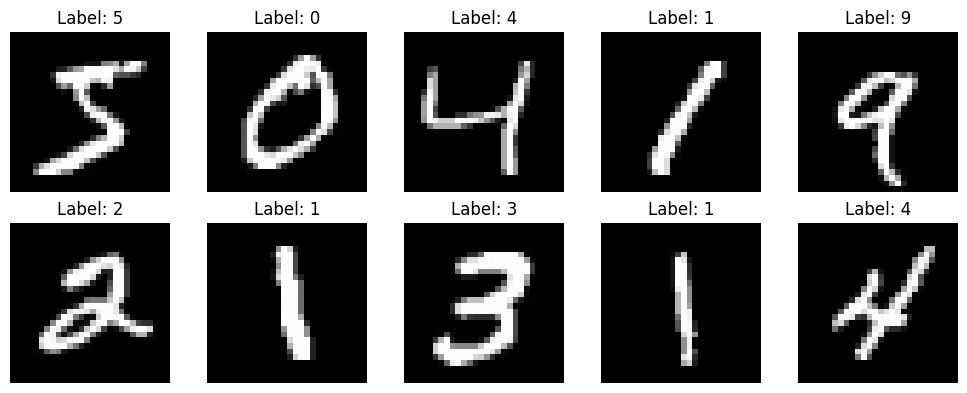

In [10]:
# Ver ejemplos de MNIST (recomendado): carga directa con torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision import transforms

transform = transforms.ToTensor()

train_ds = MNIST(root="data", train=True, download=True, transform=transform)
test_ds  = MNIST(root="data", train=False, download=True, transform=transform)

print("Train size:", len(train_ds))
print("Test size :", len(test_ds))

# Mostrar 10 ejemplos del set de entrenamiento
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.ravel()):
    img, label = train_ds[i]            # img: Tensor [1, 28, 28]
    ax.imshow(img.squeeze(0), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.tight_layout()
plt.show()


## 6) Evaluacion en Test

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, confusion_matrix

# --- Cargar checkpoint de forma segura ---
state = torch.load(
    ckpt_path,
    map_location=DEVICE,
    weights_only=True   # <- elimina el FutureWarning
)

# Soporta checkpoints con o sin diccionario
if isinstance(state, dict) and "model" in state:
    model.load_state_dict(state["model"])
else:
    model.load_state_dict(state)

model.to(DEVICE)
model.eval()

# --- Evaluación ---
test_l, test_a, y_pred, y_true = evaluate(
    model, test_loader, criterion, DEVICE
)

print(f"Test: loss={test_l:.4f} acc={test_a:.4f}")

print("\nReporte de clasificación:")
print(classification_report(y_true, y_pred, digits=4))


Test: loss=0.0230 acc=0.9911

Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.9879    0.9959    0.9919       980
           1     0.9930    0.9965    0.9947      1135
           2     0.9922    0.9903    0.9913      1032
           3     0.9921    0.9921    0.9921      1010
           4     0.9939    0.9949    0.9944       982
           5     0.9811    0.9899    0.9855       892
           6     0.9958    0.9875    0.9916       958
           7     0.9893    0.9903    0.9898      1028
           8     0.9908    0.9928    0.9918       974
           9     0.9940    0.9802    0.9870      1009

    accuracy                         0.9911     10000
   macro avg     0.9910    0.9910    0.9910     10000
weighted avg     0.9911    0.9911    0.9911     10000



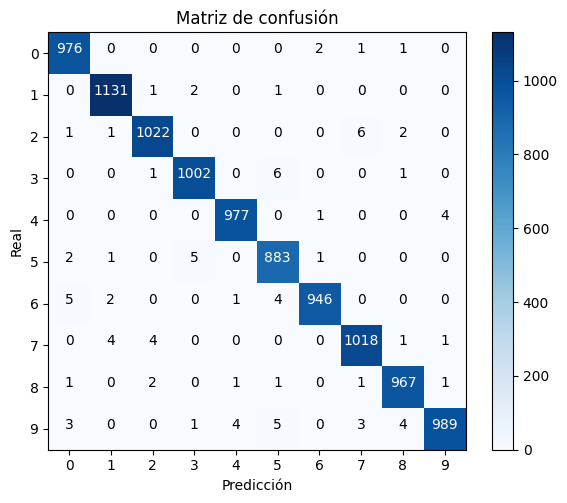

In [12]:
def plot_confusion(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap="Blues")
    plt.title("Matriz de confusión")
    plt.colorbar()

    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes)
    plt.yticks(ticks, classes)

    thr = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, i, cm[i, j],
            ha="center",
            color="white" if cm[i, j] > thr else "black"
        )

    plt.ylabel("Real")
    plt.xlabel("Predicción")
    plt.tight_layout()
    plt.show()


plot_confusion(y_true, y_pred, [str(i) for i in range(10)])


## 7) Camara: preprocesamiento y prediccion

In [13]:

def preprocess_digit_from_frame(frame, roi=None):
    # Preprocesa ROI para MNIST
    # 1 gris, 2 suavizado y umbral invertido, 3 contorno principal y recorte,
    # 4 padding cuadrado y resize 28x28, 5 normalizar con mean/std MNIST,
    # 6 devolver tensor [1,1,28,28] en DEVICE
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    if roi is not None:
        x, y, w, h = roi
        gray = gray[y:y+h, x:x+w]

    blur = cv2.GaussianBlur(gray, (5,5), 0)
    th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    contours, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return None, th

    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    digit = th[y:y+h, x:x+w]

    size = max(w, h)
    sq = np.zeros((size, size), dtype=np.uint8)
    sq[(size-h)//2:(size-h)//2+h, (size-w)//2:(size-w)//2+w] = digit

    digit28 = cv2.resize(sq, (28,28), interpolation=cv2.INTER_AREA)
    dn = (digit28.astype("float32")/255.0 - MNIST_MEAN[0]) / MNIST_STD[0]

    tens = torch.from_numpy(dn).unsqueeze(0).unsqueeze(0).to(DEVICE)
    return tens, th

def predict_digit(model, tensor_1x1x28x28):
    model.eval()
    with torch.no_grad():
        logits = model(tensor_1x1x28x28)
        prob = torch.softmax(logits, dim=1)
        pred = prob.argmax(dim=1).item()
        conf = prob.max(dim=1).values.item()
    return pred, conf


## 8) Bucle de camara

In [14]:
# === Inferencia en tiempo real con cámara (OpenCV) ===
# Teclas:
#   p = predecir el dígito dentro del recuadro (ROI)
#   r = re-centrar ROI (se recalcula según el tamaño del frame actual)
#   q = salir

from pathlib import Path
import cv2
import numpy as np
import torch

# 1) Asegurar que el modelo esté cargado
if 'model' not in globals():
    model = MNIST_CNN().to(DEVICE)

if Path(ckpt_path).exists():
    state = torch.load(ckpt_path, map_location=DEVICE)
    # Compatible con guardados tipo {"model": state_dict, ...} o state_dict directo
    sd = state["model"] if isinstance(state, dict) and "model" in state else state
    model.load_state_dict(sd)
else:
    print(f"[AVISO] No encontré el checkpoint en {ckpt_path}.")
    print("        Entrena primero o ajusta ckpt_path para cargar tu modelo.")
    # Igual dejamos el loop listo; solo que las predicciones no serán buenas.

model.eval()

# 2) Abrir cámara con fallback de backends (Windows suele ir mejor con CAP_DSHOW)
def open_camera(preferred_index=0):
    backends = [
        (cv2.CAP_DSHOW, "CAP_DSHOW"),
        (cv2.CAP_MSMF, "CAP_MSMF"),
        (cv2.CAP_ANY,  "CAP_ANY"),
    ]
    for idx in [preferred_index, 1, 2]:
        for backend, name in backends:
            cap = cv2.VideoCapture(idx, backend)
            if cap.isOpened():
                print(f"[OK] Cámara abierta: index={idx}, backend={name}")
                return cap
            cap.release()
    return None

cap = open_camera(0)
if cap is None:
    raise RuntimeError("No se pudo abrir ninguna cámara. Revisa permisos/driver y cierra apps que la estén usando.")

# 3) Leer 1 frame para obtener tamaño real (cap.set puede no aplicar)
ret, frame = cap.read()
if not ret:
    cap.release()
    raise RuntimeError("No se pudo leer el primer frame de la cámara.")

h, w = frame.shape[:2]

def make_roi(w, h, roi_size=300):
    roi_size = int(min(roi_size, w, h) * 0.9)
    rx = w//2 - roi_size//2
    ry = h//2 - roi_size//2
    return (rx, ry, roi_size, roi_size)

roi = make_roi(w, h, roi_size=300)
pred_text = ""

print("Cámara activa. 'p'=predecir, 'r'=recentrar ROI, 'q'=salir.")

while True:
    ret, frame = cap.read()
    if not ret:
        print("No se pudo leer frame."); break

    h, w = frame.shape[:2]
    rx, ry, rw, rh = roi

    # Si cambió el tamaño del frame (pasa a veces), re-hacer ROI
    if rx+rw > w or ry+rh > h:
        roi = make_roi(w, h, roi_size=min(rw, rh))
        rx, ry, rw, rh = roi

    # Dibujar ROI
    cv2.rectangle(frame, (rx, ry), (rx+rw, ry+rh), (0, 255, 0), 2)

    if pred_text:
        cv2.putText(frame, pred_text, (20, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.1, (0,255,0), 2, cv2.LINE_AA)

    cv2.imshow("MNIST Cam", frame)
    key = cv2.waitKey(1) & 0xFF

    if key == ord('p'):
        tens, th = preprocess_digit_from_frame(frame, roi=roi)
        if tens is None:
            pred_text = "No se detectó dígito"
        else:
            pred, conf = predict_digit(model, tens)
            pred_text = f"Pred: {pred} (conf: {conf:.2f})"
            cv2.imshow("Segmentación", th)

    elif key == ord('r'):
        roi = make_roi(w, h, roi_size=min(rw, rh))
        pred_text = ""

    elif key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


[OK] Cámara abierta: index=0, backend=CAP_DSHOW
Cámara activa. 'p'=predecir, 'r'=recentrar ROI, 'q'=salir.


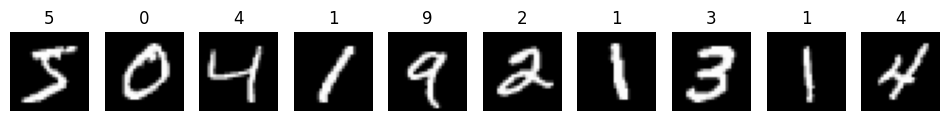

In [13]:
#Muestras de imágenes

#dígito (del 0 al 9) en su formato original (28×28):

import matplotlib.pyplot as plt
from torchvision import datasets, transforms

# Descargar MNIST (solo 10 imágenes de ejemplo)
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())

fig, axes = plt.subplots(1, 10, figsize=(12, 2))
for i in range(10):
    img, label = mnist[i]
    axes[i].imshow(img.squeeze(), cmap="gray")
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()


# Visualizar a través del Dataset 

Tamaño del dataset (train): 60000


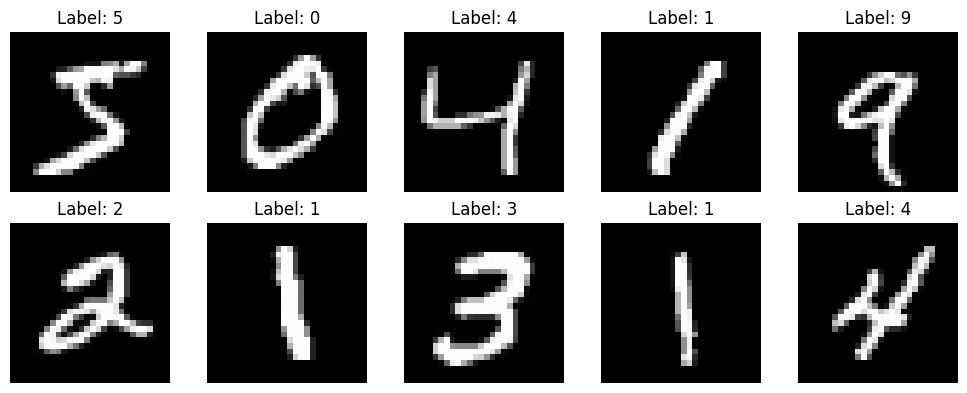

In [14]:
from torchvision import datasets, transforms

ds = datasets.MNIST(root="data", train=True, download=False, transform=transforms.ToTensor())
print("Tamaño del dataset (train):", len(ds))

# Mostrar 10 ejemplos directamente del dataset
fig, axes = plt.subplots(2, 5, figsize=(10,4))
for i, ax in enumerate(axes.ravel()):
    img, label = ds[i]  # img es tensor 1x28x28
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.tight_layout()
plt.show()
